### Deploying a Machine Learning Model using fastAPI

This lab was conducted under the guidance of the online course “Introduction to Machine Learning in Production” in Coursera, and part of the code was provided there.

We deploy a computer vision neural network trained to detect common objects  in pictures. The model has been evaluated with two different datasets. 

As regards the first experiment, we follow the guidance of the lab instructions and we run our model to perform object detection on the ImageNet dataset. 
Regarding the second experiment, we run our model in a completely different task. Hence, we perform gender detection on the CelebA dataset.

The sequence of tasks to complete are as follows:

1. Inspect the image data sets used for object detection.
2. Take a look at the model itself.
3. Deploy the model using fastAPI.

### But first.. do the installations.

In [2]:
pip install --requirement ./requirements.txt

Note: you may need to restart the kernel to use updated packages.


### 1. Object detection task 
#### Review the dataset

These images are part of the ImageNet dataset.

In [13]:
from IPython.display import Image, display


Displaying image: apple.jpeg


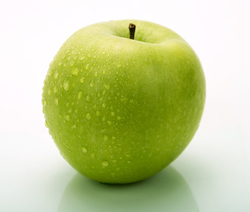


Displaying image: clock.jpeg


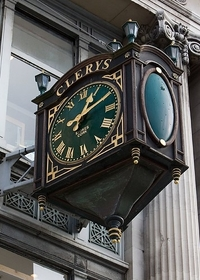

In [14]:
# Some example images
image_files = [
    'apple.jpeg',
    'clock.jpeg'
]

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"images/{image_file}"))

### Overview of the model

Now that we have a sense of the dataset and the objects present, let's try and see if the model is able to detect and classify them correctly.

For this we will be using cvlib, which is a very powerful library for object detection.

Moreover, before using the object detection neural network, we build the output directory for the output images.

In [15]:
import os

dir_name = "images_with_boxes"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

Let's define the detect_and_draw_box function which takes as input arguments: the filename of a file on your system, a model, and a confidence level. With these inputs, it detects common objects in the image and saves a new image displaying the bounding boxes alongside the detected object.

In [16]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox

In [17]:
def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))

Image processed: apple.jpeg

Detected object: apple with confidence level of 0.5717207193374634



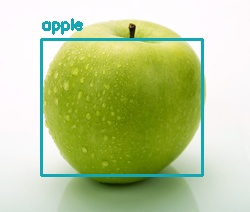

Image processed: clock.jpeg

Detected object: clock with confidence level of 0.9683184623718262



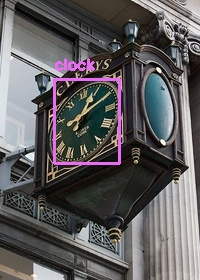

In [8]:
for image_file in image_files:
    detect_and_draw_box(image_file)

Image processed: fruits.jpeg

Detected object: apple with confidence level of 0.5818484425544739

Detected object: orange with confidence level of 0.5346481800079346

Detected object: orange with confidence level of 0.5150994658470154



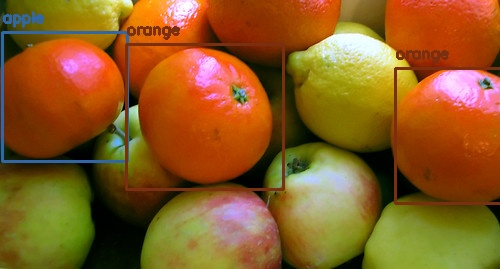

In [18]:
detect_and_draw_box("fruits.jpeg")

Image processed: fruits.jpeg

Detected object: apple with confidence level of 0.5818484425544739

Detected object: orange with confidence level of 0.5346481800079346

Detected object: orange with confidence level of 0.5150994658470154

Detected object: apple with confidence level of 0.3475988507270813

Detected object: orange with confidence level of 0.32876113057136536

Detected object: apple with confidence level of 0.3124468922615051

Detected object: orange with confidence level of 0.2798609137535095

Detected object: orange with confidence level of 0.27499765157699585

Detected object: apple with confidence level of 0.2744506001472473

Detected object: orange with confidence level of 0.21419109404087067



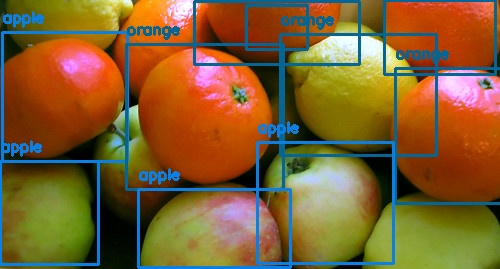

In [9]:
detect_and_draw_box("fruits.jpeg", confidence=0.2)

By lowering the confidence level the model successfully detects most of the fruits. However, in order to correctly detect the objects present, we had to set the confidence level really low. In general, we should be careful when decreasing or increasing these kinds of parameters, as changing them might yield to undesired results.

As for this example when an orange was misclassified as an apple, it serves as a reminder that these models are not perfect and this should be considered when using them for tasks in production.

### Deploying the model using fastAPI

#### Placing the model in a server

Before diving into deployment, let's quickly create a directory to store the images that are uploaded to the server.

In [10]:
dir_name = "images_uploaded"

if not os.path.exists(dir_name):
    os.mkdir(dir_name)

### Some concept clarifications
#### Client-Server model

The main task of a deployment procedure is to upload the software/the ML model in a server, which is going to receive requests for predictions. When a client makes a request, he also should provide the required information that the server needs in order to answer this request for prediction. The server will use the information provided to return predictions to the client.

Let's get started by creating an instance of the FastAPI class:
`app = FastAPI()`

The next step is using this instance to create endpoints that will handle the logic for predicting. Once all the code is in place to run the server you only need to use the command:
`uvicorn.run(app)`

Your API is coded using fastAPI but the serving is done using uvicorn, which is a really fast Asynchronous Server Gateway Interface (ASGI) implementation. Both technologies are closely interconnected and you don't need to understand the implementation details. Knowing that uvicorn handles the serving is sufficient for the purpose of this lab.

#### Endpoints
You can host multiple Machine Learning models on the same server. For this, you can assign a different endpoint to each model so you always know what model is being used. An endpoint is represented by a pattern in the URL. 

In **fastAPI** you define an endpoint by creating a function that will handle all of the logic for that endpoint and decorating it with a function that contains information on the HTTP method allowed and the pattern in the URL that it will use.

#### HTTP requests
If your client does a *GET request* to an endpoint of a server you will get some information from this endpoint without the need to provide additional information. 

In the case of a *POST request* you are explicitly telling the server that you will provide some information for it that must be processed in some way.

#### Why fastAPI?
With fastAPI you can create web servers to host your models very easily. Additionally, this platform is extremely fast and it has a built-in client that can be used to interact with the server. To use it you will need to visit the "/docs" endpoint, for this case this means to visit http://localhost:8000/docs. Isn't that convenient?

In [19]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from cvlib.object_detection import draw_bbox
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [20]:
# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Deploying a ML Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"

# Allow the GET method to work for theendpoint.
@app.get("/")
def home():
    return "The API is working as expected. Now head over to http://localhost:8000/docs."


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
        
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

#### Start running the server

This causes the notebook to block (no cells/code can run) until you manually interrupt the kernel. You can do this by clicking on the Kernel tab and then on Interrupt. You can also enter Jupyter's command mode by pressing the ESC key and tapping the I key twice.

By design **asyncio** does not allow its event loop to be nested. This presents a practical problem: When in an environment where the event loop is already running it’s impossible to run tasks and wait for the result. Trying to do so will give the error “RuntimeError: This event loop is already running”.

The issue pops up in various environments, such as web servers, GUI applications and in Jupyter notebooks.

This module patches asyncio to allow nested use of asyncio.run and loop.run_until_complete.

In [ ]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" 
#if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [8514]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     172.17.0.1:61482 - "GET / HTTP/1.1" 200 OK
INFO:     172.17.0.1:61480 - "GET /docs HTTP/1.1" 200 OK
INFO:     172.17.0.1:61480 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:43324 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:38822 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:38824 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:38826 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK


The server is now running! Head over to http://localhost:8000/ to see it in action.

Try submitting an image and see how your API is able to detect objects within it and return a new image containing the bounding boxes alongside the labels of the detected objects. You can do this by visiting http://localhost:8000/docs to open fastAPI's built-in client.

### 2. Gender detection task (extra experiment)
#### Review the dataset

These images are part of the CelebA dataset.

Credits to https://github.com/arunponnusamy/cvlib/blob/master/examples/gender_detection.py


Displaying image: 01.jpeg


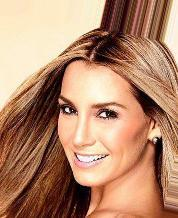


Displaying image: 03.jpeg


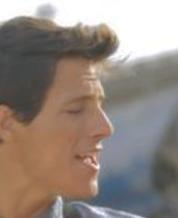

In [17]:
from IPython.display import Image, display

# Some example images
image_files = [
    '01.jpeg',
    '03.jpeg'
]

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"faces/{image_file}"))

In [14]:
import os

dir_name = "images_with_detected_faces"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [7]:
import cv2
import cvlib as cv
import numpy as np 
from IPython.display import Image, display

def detect_face(filename, confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'faces/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # First, perform the face detection
    face, conf = cv.detect_face(img)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(face, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    padding = 30 
    
    # loop through detected faces
    for f in face:
        print(f)

        (startX,startY) = max(0, f[0]-padding), max(0, f[1]-padding)
        (endX,endY) = min(img.shape[1]-1, f[2]+padding), min(img.shape[0]-1, f[3]+padding)

        # draw rectangle over face
        cv2.rectangle(img, (startX,startY), (endX,endY), (0,255,0), 2)

        face_crop = np.copy(img[startY:endY, startX:endX])

        # apply gender detection
        (label, confidence) = cv.detect_gender(face_crop)

        print(confidence)
        print(label)

        idx = np.argmax(confidence)
        label = label[idx]

        label = "{}: {:.2f}%".format(label, confidence[idx] * 100)

        Y = startY - 10 if startY - 10 > 10 else startY + 10

        cv2.putText(img, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 255, 0), 2)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_detected_faces/{filename}', img)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_detected_faces/{filename}'))
    
    # release resources
    cv2.destroyAllWindows()

Image processed: gender_detection_input.jpeg

Detected object: [534, 83, 639, 237] with confidence level of 0.999782145023346

Detected object: [216, 67, 315, 212] with confidence level of 0.9961185455322266

[534, 83, 639, 237]
[9.9997067e-01 2.9328323e-05]
['male', 'female']
[216, 67, 315, 212]
[0.20453535 0.79546463]
['male', 'female']


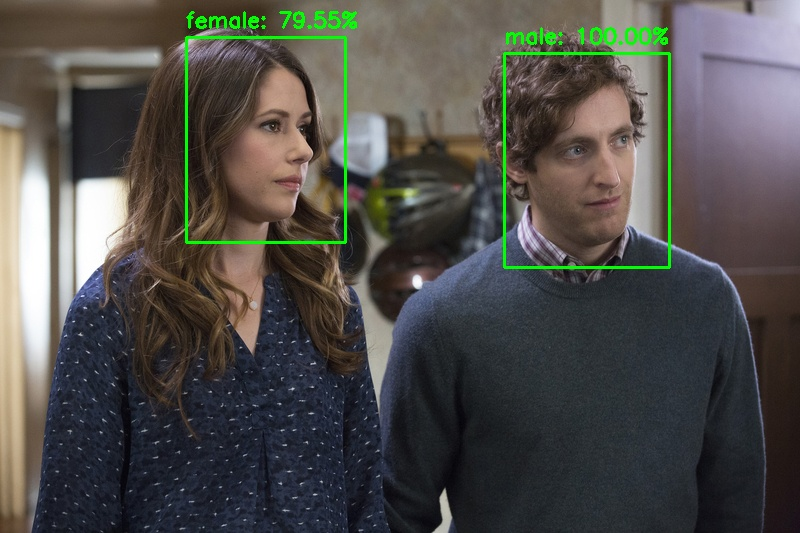

In [9]:
detect_face('gender_detection_input.jpeg')

### Deploying the model using fastAPI

#### Placing the model in a server

Before diving into deployment, let's quickly create a directory to store the images that are uploaded to the server.

In [12]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from cvlib.object_detection import draw_bbox
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Deploying a ML Model with FastAPI')

# Allow the GET method to work for theendpoint.
@app.get("/")
def home():
    return "The API is working as expected. Now head over to http://localhost:8000/docs."


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
        
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Images are stored under the images/ directory
    img_filepath = f'faces/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # First, perform the face detection
    face, conf = cv.detect_face(img)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(face, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    padding = 30 
    
    # loop through detected faces
    for f in face:

        (startX,startY) = max(0, f[0]-padding), max(0, f[1]-padding)
        (endX,endY) = min(img.shape[1]-1, f[2]+padding), min(img.shape[0]-1, f[3]+padding)

        # draw rectangle over face
        cv2.rectangle(img, (startX,startY), (endX,endY), (0,255,0), 2)

        face_crop = np.copy(img[startY:endY, startX:endX])

        # apply gender detection
        (label, confidence) = cv.detect_gender(face_crop)


        idx = np.argmax(confidence)
        label = label[idx]

        label = "{}: {:.2f}%".format(label, confidence[idx] * 100)

        Y = startY - 10 if startY - 10 > 10 else startY + 10

        cv2.putText(img, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 255, 0), 2)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_uploaded/{filename}', img)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

### Start running the server 

In [11]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" 
#if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [8514]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     172.17.0.1:56924 - "GET / HTTP/1.1" 200 OK
INFO:     172.17.0.1:55160 - "GET /docs HTTP/1.1" 200 OK
INFO:     172.17.0.1:55160 - "GET /openapi.json HTTP/1.1" 200 OK
Image processed: gender_detection_input.jpeg

Detected object: [534, 83, 639, 237] with confidence level of 0.999782145023346

Detected object: [216, 67, 315, 212] with confidence level of 0.9961185455322266

INFO:     172.17.0.1:55162 - "POST /predict HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [8514]
